In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys; sys.path.insert(0,"/home/ubuntu/fastai-fork/")
from fastai.vision.interpret import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.distributed import *
from fastai.script import *
from fastai.utils.mem import *
from deepcut import *
import datasets
from utils import *

### data

In [3]:
path, data_name = "../data/mhp/", "MHPData"
sample_size, bs, size = None, 8, (320, 320)
path = Path(path)
DatasetClass = getattr(datasets, data_name)
dataobj = DatasetClass(path=path, sample_size=sample_size, bs=bs, size=size)

In [4]:
test_data = dataobj.get_testdata()

In [5]:
test_data

ImageDataBunch;

Train: LabelList (4000 items)
x: SegmentationItemList
Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320)
y: SegmentationLabelList
ImageSegment (1, 320, 320),ImageSegment (1, 320, 320),ImageSegment (1, 320, 320),ImageSegment (1, 320, 320),ImageSegment (1, 320, 320)
Path: ../data/mhp/images;

Valid: LabelList (980 items)
x: SegmentationItemList
Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320)
y: SegmentationLabelList
ImageSegment (1, 320, 320),ImageSegment (1, 320, 320),ImageSegment (1, 320, 320),ImageSegment (1, 320, 320),ImageSegment (1, 320, 320)
Path: ../data/mhp/images;

Test: None

### load model

In [6]:
use_deepcut=0
if not use_deepcut:
    learn = unet_learner(test_data, models.resnet34, model_dir='../../../custom_segmentation', 
                         pretrained=False, self_attention=False)
else:
    m =  deepcut()
    learn = Learner(test_data, m, model_dir='../../../custom_segmentation')

In [7]:
learn.load('./best_dunet_mhp_coco++_finetune_inet_full');

In [8]:
learn.metrics = [partial(foreground_acc, void_code=0),
                 partial(multilabel_dice, classes=range(learn.data.y.c)),
                 partial(multilabel_iou, classes=range(learn.data.y.c))]

In [9]:
# learn.validate(learn.data.valid_dl)
# learn.data.train_ds.y.classes
# fig = learn.show_results(rows=10, alpha=0.8)

### interpret

In [10]:
interp = SegmentationInterpretation.from_learner(learn)

In [11]:
top_losses, top_idxs = interp.top_losses((320,320))

(array([266., 254., 161.,  91.,  61.,  50.,  34.,  18.,  16.,   7.,   9.,   5.,   4.,   0.,   1.,   1.,   1.,   0.,
          0.,   1.]),
 array([0.037359, 0.180265, 0.323172, 0.466078, 0.608985, 0.751891, 0.894798, 1.037704, 1.180611, 1.323517, 1.466424,
        1.60933 , 1.752237, 1.895144, 2.03805 , 2.180957, 2.323863, 2.46677 , 2.609676, 2.752583, 2.895489],
       dtype=float32),
 <a list of 20 Patch objects>)

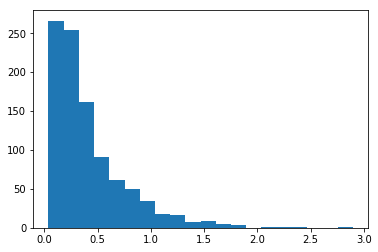

In [12]:
# plot loss distribution
plt.hist(to_np(top_losses), bins=20)

In [13]:
# top loss idxs of images
top_idxs[:5]

tensor([457, 730, 710, 449, 143])

### single image class dice, iou

In [14]:
# from utils import *

# interp.preds.shape, interp.y_true.shape

# classes = interp.data.classes

# dice_scores = multilabel_dice(interp.preds[0][None,:], interp.y_true[0][None,:], range(interp.data.c), reduce=None)

# dice_scores = multilabel_dice(interp.preds[0][None,:], interp.y_true[0][None,:], range(interp.data.c), reduce=None)
# dict(zip(classes, dice_scores))

# iou_scores = multilabel_iou(interp.preds[0][None,:], interp.y_true[0][None,:], range(interp.data.c), reduce=None)
# dict(zip(classes, iou_scores))

# interp.data.classes

# interp.show_xyz(0)

### confusion matrix

In [15]:
mean_cm, single_img_cm = interp._generate_confusion()

In [19]:
mean_cm.shape, single_img_cm.shape

((16, 16), (980, 16, 16))

### bring it all together

label,score
background,0.971414
face,0.857424
upper-clothes,0.848346
pants,0.805696
hair,0.703072
leg,0.639253
shoe,0.610014
dress,0.570214
arm,0.551492
hat,0.459059


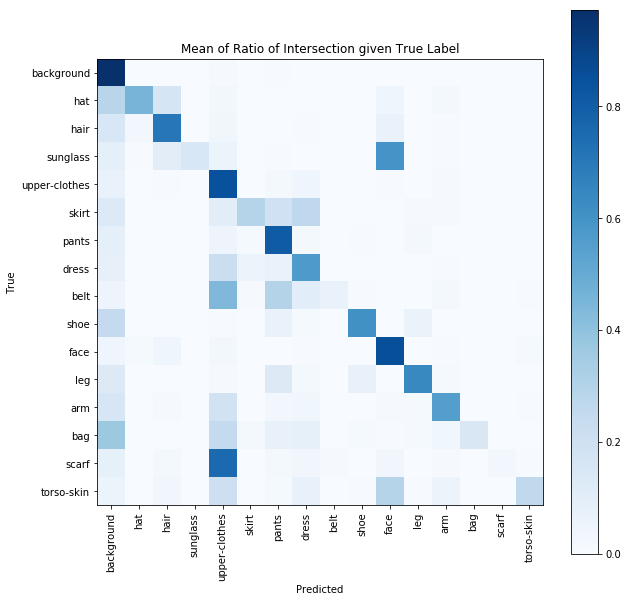

In [17]:
# global class performance
df = interp._plot_intersect_cm(mean_cm, "Mean of Ratio of Intersection given True Label")

label,score
background,0.965268
torso-skin,0.901316
hair,0.843732
arm,0.727888
pants,0.312183
face,0.155437
dress,0
hat,NaN
sunglass,NaN
upper-clothes,NaN


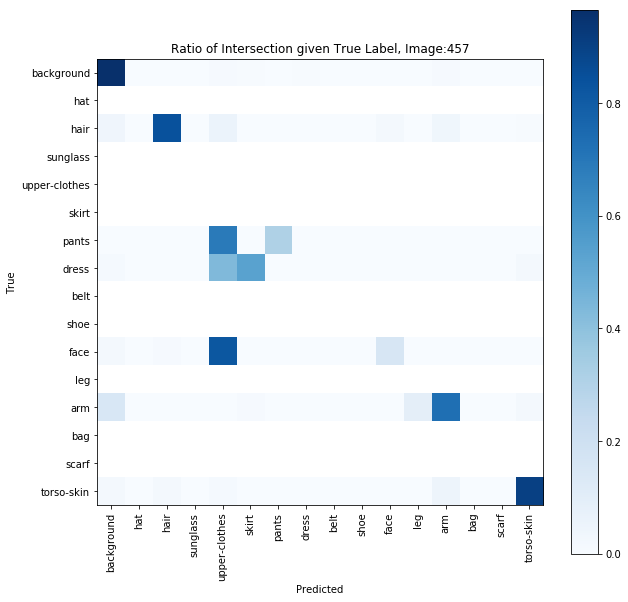

In [21]:
# single image class performance
i = 457
df = interp._plot_intersect_cm(single_img_cm[i], f"Ratio of Intersection given True Label, Image:{i}")

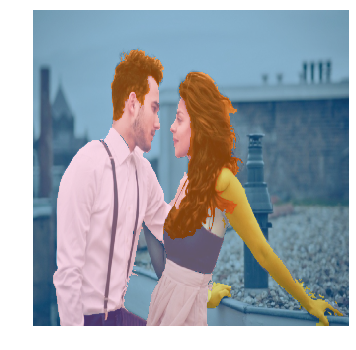

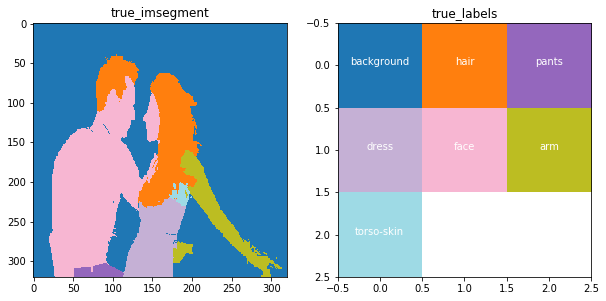

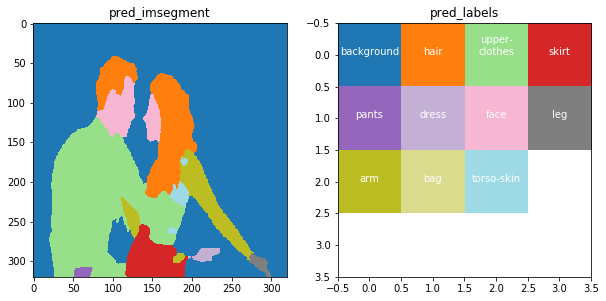

In [23]:
# show xyz
interp.show_xyz(i)